In [1]:
import pandas as pd
import numpy as np
import pickle
from sklearn.metrics import make_scorer, r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.signal import savgol_filter
from sklearn.cross_decomposition import PLSRegression
from scipy import stats
import os
from ChemUtils import GlobalStandardScaler, EmscScaler
import random
from sklearn.model_selection import KFold, cross_val_score
from scipy.stats import median_abs_deviation
import matplotlib.pyplot as plt
from sys import stdout
from scipy.stats import f
from sklearn.model_selection import cross_val_predict
import obspy
from obspy.signal.detrend import polynomial
import seaborn as sns 
import scipy.io as sio
from joblib import load
import peval 
# from model_cnn import *

import tensorflow as tf
from livelossplot import PlotLossesKerasTF
from tensorflow import keras 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.layers import Conv1D, Reshape
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, concatenate
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint


In [2]:
# read in the data from the pickle file
with open('/root/autodl-tmp/vertigo/data/2_outlier_removal.pkl', 'rb') as f:
    df_outlier = pickle.load(f)


with open('/root/autodl-tmp/vertigo/data/2_clean_data.pkl', 'rb') as f:
    df_clean = pickle.load(f)

with open('/root/autodl-tmp/vertigo/data/2_outlier_removal_pls.pkl', 'rb') as f:
    df_clean_pls = pickle.load(f)

df = df_clean.copy()
# print(df.shape)

In [3]:
# Separate spectral data and quality attributes
spectral_cols = [col for col in df.columns if 'GHz' in col]
quality_attrs = ['Brix', 'TA', 'Firmness (kg)']

X = df[spectral_cols]
y = df[quality_attrs]

# Split data into train (70%) and temp (30%) - now using all targets
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, shuffle=True
)

# Split temp into validation (10%) and test (20%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=2/3, random_state=42, shuffle=True
)

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(X_train)
x_test_scaled = scaler.transform(X_test)
x_val_scaled = scaler.transform(X_val)

def reproducible_comp():
    os.environ['PYTHONHASHSEED'] = '0'
    np.random.seed(42)
    random.seed(42)
    tf.random.set_seed(42)
    
## Make computations reproducible
reproducible_comp()


# Separate and scale targets
y_train_orig = y_train.copy()
y_val_orig = y_val.copy()
y_test_orig = y_test.copy()

# Initialize scalers for each target
target_scalers = {
    'brix': StandardScaler(),
    'ta': StandardScaler(),
    'firmness': StandardScaler()
}

# Scale training targets
y_train_scaled = pd.DataFrame({
    'Brix': target_scalers['brix'].fit_transform(y_train[['Brix']]).flatten(),
    'TA': target_scalers['ta'].fit_transform(y_train[['TA']]).flatten(),
    'Firmness (kg)': target_scalers['firmness'].fit_transform(y_train[['Firmness (kg)']]).flatten()
})

# Scale validation/test using training statistics
y_val_scaled = pd.DataFrame({
    'Brix': target_scalers['brix'].transform(y_val[['Brix']]).flatten(),
    'TA': target_scalers['ta'].transform(y_val[['TA']]).flatten(),
    'Firmness (kg)': target_scalers['firmness'].transform(y_val[['Firmness (kg)']]).flatten()
})

y_test_scaled = pd.DataFrame({
    'Brix': target_scalers['brix'].transform(y_test[['Brix']]).flatten(),
    'TA': target_scalers['ta'].transform(y_test[['TA']]).flatten(),
    'Firmness (kg)': target_scalers['firmness'].transform(y_test[['Firmness (kg)']]).flatten()
})

In [4]:
## Layers dimensions
INPUT_DIMS = np.shape(X_train)[1]
CONV1D_DIMS = INPUT_DIMS
K_NUMBER = 1
K_WIDTH = 5
K_STRIDE = 1
FC1_DIMS = 36
FC2_DIMS = 18
FC3_DIMS = 12

## L2 regularizer parameter
beta = 0.003/2.

## Weights initialization
K_INIT = tf.keras.initializers.he_normal(seed=42)

## Weights L2 regularization 
K_REG = tf.keras.regularizers.l2(beta)

## Input layer
input_layer = keras.layers.Input(shape=(INPUT_DIMS,))

## Reshape and Conv1D layers
x = keras.layers.Reshape((INPUT_DIMS, 1))(input_layer)
x = keras.layers.Conv1D(filters=K_NUMBER,
                       kernel_size=K_WIDTH,
                       strides=K_STRIDE,
                       padding='same',
                       kernel_initializer=K_INIT,
                       kernel_regularizer=K_REG,
                       activation='elu')(x)
x = keras.layers.Flatten()(x)

## Shared dense layers
x = keras.layers.Dense(FC1_DIMS,
                      kernel_initializer=K_INIT,
                      kernel_regularizer=K_REG,
                      activation='elu')(x)
x = keras.layers.Dense(FC2_DIMS,
                      kernel_initializer=K_INIT,
                      kernel_regularizer=K_REG,
                      activation='elu')(x)
shared_features = keras.layers.Dense(FC3_DIMS,
                                   kernel_initializer=K_INIT,
                                   kernel_regularizer=K_REG,
                                   activation='elu')(x)

## Task-specific output layers
brix_out = keras.layers.Dense(1, name='brix',
                             kernel_initializer=K_INIT,
                             kernel_regularizer=K_REG,
                             activation='linear')(shared_features)
ta_out = keras.layers.Dense(1, name='ta',
                           kernel_initializer=K_INIT,
                           kernel_regularizer=K_REG,
                           activation='linear')(shared_features)
firmness_out = keras.layers.Dense(1, name='firmness',
                                 kernel_initializer=K_INIT,
                                 kernel_regularizer=K_REG,
                                 activation='linear')(shared_features)

## Create multi-output model
model_multi = keras.Model(inputs=input_layer,
                         outputs=[brix_out, ta_out, firmness_out])

print(model_multi.summary())



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 112)]        0           []                               
                                                                                                  
 reshape (Reshape)              (None, 112, 1)       0           ['input_1[0][0]']                
                                                                                                  
 conv1d (Conv1D)                (None, 112, 1)       6           ['reshape[0][0]']                
                                                                                                  
 flatten (Flatten)              (None, 112)          0           ['conv1d[0][0]']                 
                                                                                              

2025-05-12 15:55:39.746618: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-12 15:55:40.425990: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22182 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:a1:00.0, compute capability: 8.6


In [5]:
class MultiTaskPlotCallback(keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.metrics = {}
        # Initialize all possible metrics
        for metric in ['loss'] + \
                     [f'{k}_{m}' for k in ['brix', 'ta', 'firmness'] for m in ['loss']]:
            self.metrics[metric] = []
            self.metrics[f'val_{metric}'] = []
    
    def on_epoch_end(self, epoch, logs=None):
        # Update all available metrics
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs[metric])

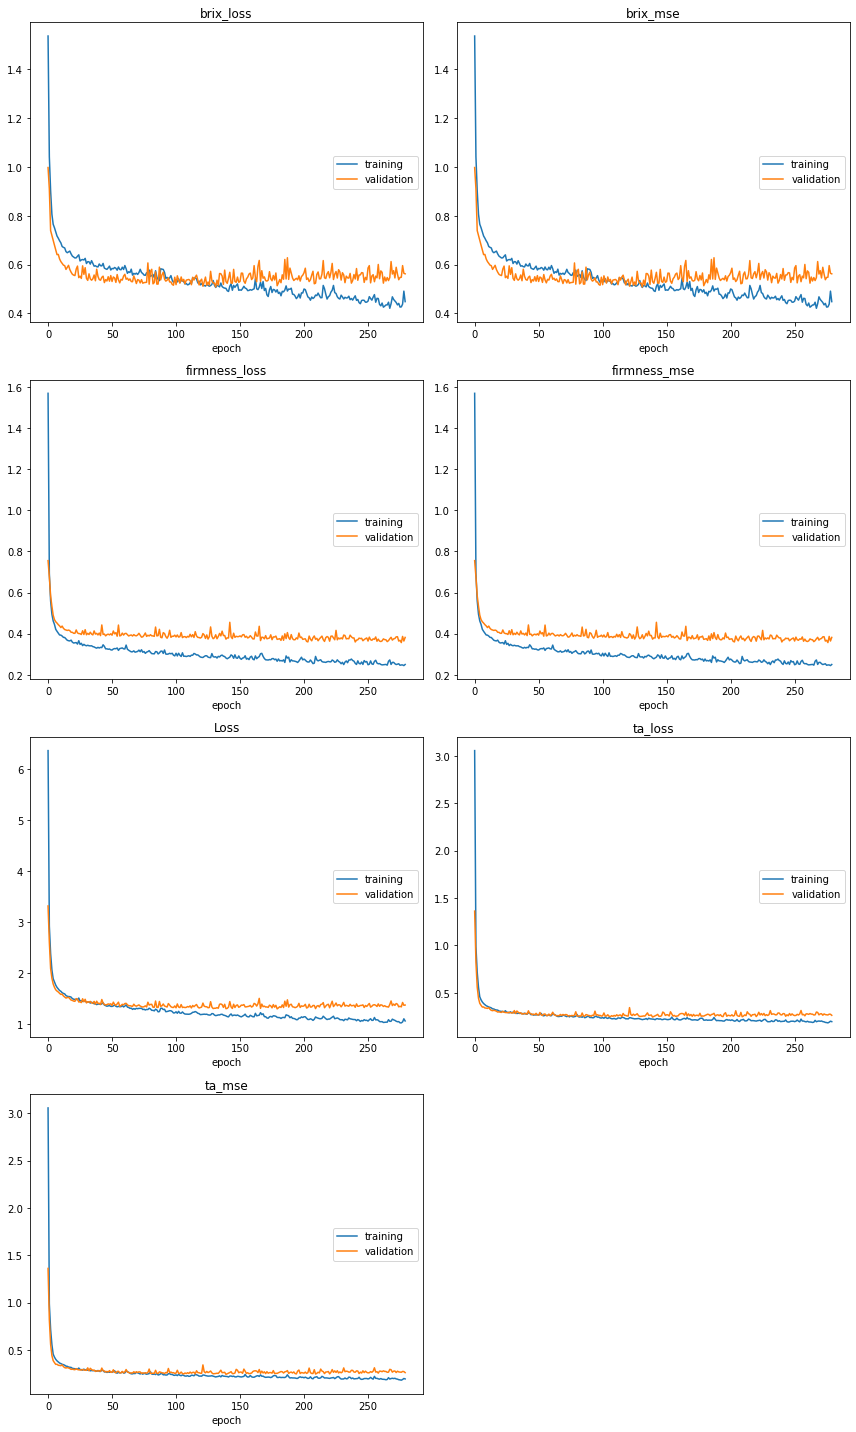

brix_loss
	training         	 (min:    0.421, max:    1.536, cur:    0.448)
	validation       	 (min:    0.508, max:    0.997, cur:    0.562)
brix_mse
	training         	 (min:    0.421, max:    1.536, cur:    0.448)
	validation       	 (min:    0.508, max:    0.997, cur:    0.562)
firmness_loss
	training         	 (min:    0.245, max:    1.569, cur:    0.250)
	validation       	 (min:    0.356, max:    0.755, cur:    0.382)
firmness_mse
	training         	 (min:    0.245, max:    1.569, cur:    0.250)
	validation       	 (min:    0.356, max:    0.755, cur:    0.382)
Loss
	training         	 (min:    1.027, max:    6.368, cur:    1.065)
	validation       	 (min:    1.301, max:    3.321, cur:    1.377)
ta_loss
	training         	 (min:    0.182, max:    3.056, cur:    0.195)
	validation       	 (min:    0.243, max:    1.362, cur:    0.262)
ta_mse
	training         	 (min:    0.182, max:    3.056, cur:    0.195)
	validation       	 (min:    0.243, max:    1.362, cur:    0.262)

Epoch 280

In [6]:
plot_losses = PlotLossesKerasTF()

## Training parameters
BATCH = 256    
LR = 0.01 * BATCH / 256.

print('Adam learning rate = {}'.format(LR))

## Compile with different loss weights based on target scales
model_multi.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
    loss={
        'brix': 'mse',
        'ta': 'mse',
        'firmness': 'mse'
    },
    loss_weights={'brix': 1.0, 'ta': 1.0, 'firmness': 1.0},
    metrics={
        'brix': ['mse'],
        'ta': ['mse'],
        'firmness': ['mse']
    }
)

## Callbacks
checkpointer = keras.callbacks.ModelCheckpoint(
    filepath="combine_cnn/df_clean.h5",
    verbose=1,
    save_best_only=True,
    monitor='val_loss'
)
early_stopping = keras.callbacks.EarlyStopping(
    patience=100,
    restore_best_weights=True
)

## Train the model
history = model_multi.fit(
    x_train_scaled,
    {
        'brix': y_train_scaled['Brix'],
        'ta': y_train_scaled['TA'],
        'firmness': y_train_scaled['Firmness (kg)']
    },
    batch_size=BATCH,
    epochs=1500,
    validation_data=(
        x_val_scaled,
        {
            'brix': y_val_scaled['Brix'],
            'ta': y_val_scaled['TA'],
            'firmness': y_val_scaled['Firmness (kg)']
        }
    ),
    callbacks=[plot_losses, MultiTaskPlotCallback(), checkpointer, early_stopping],
    verbose=1
)



In [9]:
## Load saved best parameters
model_multi.load_weights('combine_cnn/df_clean_pls.h5')

## Evaluate on test set
test_results = model_multi.evaluate(
    x_test_scaled,
    {
        'brix': y_test_scaled['Brix'],  # Use SCALED targets for evaluation
        'ta': y_test_scaled['TA'],
        'firmness': y_test_scaled['Firmness (kg)']
    },
    verbose=0
)

## Print overall test loss
print(f"\nTest Loss: {test_results[0]:.4f}")

## Get predictions and inverse scaling
y_pred_test_scaled = model_multi.predict(x_test_scaled)

# Inverse transform predictions
y_pred_brix = target_scalers['brix'].inverse_transform(y_pred_test_scaled[0]).flatten()
y_pred_ta = target_scalers['ta'].inverse_transform(y_pred_test_scaled[1]).flatten()
y_pred_firmness = target_scalers['firmness'].inverse_transform(y_pred_test_scaled[2]).flatten()

## Calculate metrics for each target (using original scale y_test)
def print_metrics(y_true, y_pred, target_name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"{target_name}:")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  R²: {r2:.4f}")
    return rmse, r2

print("\nTest Set Performance:")
brix_rmse, brix_r2 = print_metrics(y_test_orig['Brix'], y_pred_brix, 'Brix')
ta_rmse, ta_r2 = print_metrics(y_test_orig['TA'], y_pred_ta, 'TA')
firmness_rmse, firmness_r2 = print_metrics(y_test_orig['Firmness (kg)'], y_pred_firmness, 'Firmness')


Test Loss: 1.1326
16/16 [==============================] - 0s 2ms/step

Test Set Performance:
Brix:
  RMSE: 0.5411
  R²: 0.4634
TA:
  RMSE: 0.0720
  R²: 0.7274
Firmness:
  RMSE: 0.7034
  R²: 0.6964


TA Metrics:


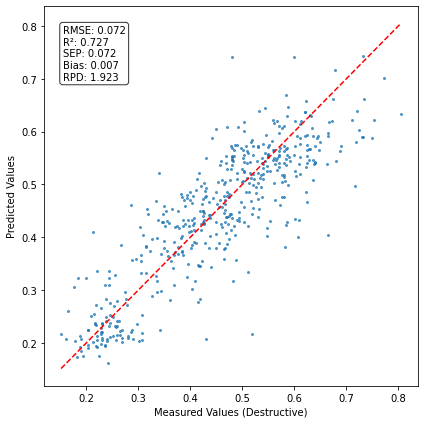

{'r2': 0.7274385126000885, 'rmse': 0.07197281552568026, 'sep': 0.0717503878973246, 'bias': 0.006527221388363642, 'rpd': 1.923362344434181}

Brix Metrics:


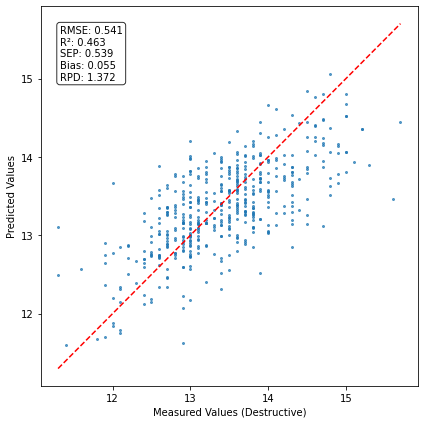

{'r2': 0.4634477370200818, 'rmse': 0.5410781238489021, 'sep': 0.5388697261129047, 'bias': 0.05463436891224757, 'rpd': 1.3722059243008706}

Firmness Metrics:


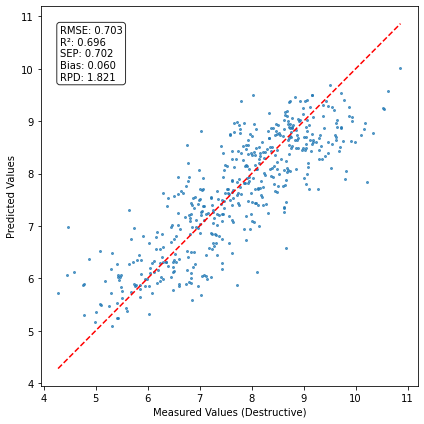

{'r2': 0.696360791763651, 'rmse': 0.70335578271605, 'sep': 0.7015066118998556, 'bias': 0.060121459506954925, 'rpd': 1.8214341881079397}


In [10]:
print("TA Metrics:")
ta_metrics_test = peval.calculate_metrics(y_true=y_test_orig['TA'].values, y_pred=y_pred_ta)
print(ta_metrics_test)

print("\nBrix Metrics:")
brix_metrics_test = peval.calculate_metrics(y_true=y_test_orig['Brix'].values, y_pred=y_pred_brix)
print(brix_metrics_test)

print("\nFirmness Metrics:")
firmness_metrics_test = peval.calculate_metrics(y_true=y_test_orig['Firmness (kg)'].values, y_pred=y_pred_firmness)
print(firmness_metrics_test)